## Data Scientist Challenge

#### Question 1

##### Listening behavior on playlists is analyzed using the following tables:
● playlists table with columns:

○ user_id : the user who uploaded the playlist

○ playlist_id : the unique identifier of the playlist

● listings table with columns:

○ playlist_id : the unique identifier of the playlist

○ track_id : the unique identifier of the track

○ position : the position of this track in the playlist

○ track_duration : the length of the track recording (in milliseconds)

● plays table with columns:

○ timestamp : the time the play occurred

○ user_id : the user who played the given track

○ track_id : the unique identifier of the track

○ playlist_id : the unique identifier of the playlist (set to 0 if the play did not happen in a playlist)

○ listening_duration : the duration that the user listened to the track (in milliseconds)

### 1.1 Given a user X, what are their 3 most listened to playlists?

###### Approach
1. Inner query will return the listned playlist of user x & outer query return the top 3 playlist id of User X.

2.  "X user id" is placeholder to replace the user id of X.

In [ ]:
Select playlist_id 
(Select 
playlist_id, 
sum(listening_duration) 
from plays where user_id="X user id" 
Group by playlist_id
Order by sum(listening_duration) desc) a 
where rownum<=3 

### 1.2 What is the percentage of users that create playlists only containing dj-sets? Assume a dj-set is a track with a duration longer than 10min.


###### Approach
1. Couting the distinct customer which has listned the track more than 10 min & on other hand counting the total distinct customer.

2. Calculating the % based on above query results.

In [ ]:
select 
((Select count(distinct(user_id)) from plays where track_id in 
  (select track_id from listings where track_duration>600000))/
 (select count(distinct(user_id)) from plays))*100 
from dual

#Seems to wrong , As I have considered the all playlist which has one track as dj-sets 
#but they mentioned playlist only containing dj-sets.

### 1.3 For a user X, recommend 5 playlists they would like that they haven’t heard before. Go for a practical over elaborate solution and stick to something that works well in SQL.


###### Approach
User X will be more likely to listen the songs which other people listening on same timestamp.

1. Using inner query finding out the list of playlist which listend on User X timestamp but not by User X.
2. Suggesting the top 5 playlist based on listening Duration. 

In [ ]:
Select playlist_id 
(Select playlist_id, 
sum(listening_duration) 
from plays 
where 
timestamp in (select timestamp from plays where user_id="X user id")                   
and user_id !="X user id" 
Group by playlist_id
Order by sum(listening_duration) desc) a 
where rownum<=5 

## Question 2


What factors affect a listener’s choice to skip a recommended track

#### MetaData 
JSON-formatted dataset describing a sample of users’ listening behavior on queues of tracks generated by some of SoundCloud’s recommender systems. We would like to know what factors affect a listener’s choice to skip a recommended track.

In this dataset, each record (i.e., each sub-list of the “data” field) represents the total amount of time the user spent listening to a track that had been recommended before a different track was played or the listening session ended.

The provided attributes (in the “columns” field) are:

● ts : the time the user listened to the recommended track (as Unix timestamp)

● country_code : the two-character country abbreviation where the user was located at the
time of listening

● client_version : the version of the client that the listener was using

● listening_context : the section of the SoundCloud web app where the user listened to the
recommended track

○ “collection”: any of the pages in the Collection section
○ “you”: the listener’s own profile page
○ “search”: any of the pages in the Search experience
○ “stream”: the page of the Stream experience
○ “personal-recommended’: the page of the Discover experience for personalized recommendations
○ “charts”: the page of the Charts experience for trending content discovery
○ “tracks”: the dedicated page of an uploaded track
○ “users”: the profile page of another user (not the one listening)
○ “playlists”: the dedicated page of a playlist

● recommender_algorithm_name : the name of the algorithm that produced the track recommendation for the listener

○ “content-based”: an implementation of content-based filtering
○ “collaborative”: an implementation of collaborative filtering
○ “hybrid”: a hybrid implementation of content-based and collaborative filtering
○ “fallback”: a static list of the popular tracks, used only as a fallback strategy

● track_id : the unique identifier of the recommended track

● track_genre_category : the broad genre category describing the recommended track

● track_upload_date : the date the recommended track was uploaded (as Unix timestamp)

● track_duration : the length of the recommended track recording (in milliseconds)

● listen_duration : the duration that the user listened to the recommended track (in milliseconds)

● listener_id : the unique identifier of the user who listened to the recommended track

● listener_signup_date : the date the listener created their SoundCloud account (as Unix timestamp)

● listener_top_genre_category_listened : the genre category that the user has most frequently listened to (based on all their past listening in all contexts)

● listener_prev_month_listening_time : the total duration that the user listened in the previous month (in all contexts)

● listener_prev_month_avg_daily_tracks_listened : the daily mean number of distinct tracks that the user listened in the previous month (in all contexts)



### Importing the required packages

In [1]:
import pandas as pd #Used for input/output & Data exploration
from datetime import datetime #Used for handling date columns 
import missingno #Used for Checking missing values
import matplotlib.pyplot as plt #Used for visulization
import seaborn as sns #Used for Visulization
import math
import numpy as np
%matplotlib inline

In [2]:
df=pd.read_json("sc_data_science_challenge.json",orient='split')

In [3]:
df.shape

(828169, 15)

In [4]:
df.head()

,ts,country_code,client_version,listening_context,recommender_algorithm_name,track_id,track_genre_category,track_upload_date,track_duration,listen_duration,listener_id,listener_signup_date,listener_top_genre_category_listened,listener_prev_month_listening_time,listener_prev_month_avg_daily_tracks_listened
0,1467398683,GB,204.0.20,tracks,content-based,b47911d0e80d1a8a959a2b726654bbfa,Dance & Electronic,1466640000,413933,413933,0001d5755511cae40e5b32d83a3decce,1324771200,HipHop & R&B,617270940.0,22.5
1,1467398924,GB,204.0.20,tracks,content-based,1f5e4bc82ba7fc802f780870f9b69191,HipHop & R&B,1466726400,402640,110722,0001d5755511cae40e5b32d83a3decce,1324771200,HipHop & R&B,617270940.0,22.5
2,1467820636,GB,204.0.20,users,content-based,092495283958e5d00f61cf2afe970d83,Pop,1467072000,494811,193818,0001d5755511cae40e5b32d83a3decce,1324771200,HipHop & R&B,617270940.0,22.5
3,1467401951,US,36.0.8,collection,content-based,211cd7be59941679f5ea847879b3b19b,HipHop & R&B,1402272000,361585,361585,000264c5b34ad04999535c8b6a8b86e2,1379376000,HipHop & R&B,112239180.0,10.5
4,1467402159,US,36.0.8,collection,content-based,0e7ca1a7524aba84473540fa0d0ec75f,Pop,1448668800,373700,160162,000264c5b34ad04999535c8b6a8b86e2,1379376000,HipHop & R&B,112239180.0,10.5


### Handling Date columns

In [5]:
#Convert unix timestamp to Datetime
df['ts']=df['ts'].apply(lambda x:datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df['track_upload_date']=df['track_upload_date'].apply(lambda x:datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df['listener_signup_date']=df['listener_signup_date'].apply(lambda x:datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))


In [13]:
df.head()

,ts,country_code,client_version,listening_context,recommender_algorithm_name,track_id,track_genre_category,track_upload_date,track_duration,listen_duration,listener_id,listener_signup_date,listener_top_genre_category_listened,listener_prev_month_listening_time,listener_prev_month_avg_daily_tracks_listened,ts_Year,ts_Month,ts_Day,ts_Hour
0,2016-07-01 18:44:43,GB,204.0.20,tracks,content-based,b47911d0e80d1a8a959a2b726654bbfa,Dance & Electronic,2016-06-23 00:00:00,413933,413933,0001d5755511cae40e5b32d83a3decce,2011-12-25 00:00:00,HipHop & R&B,617270940.0,22.5,2016,7,4,18
1,2016-07-01 18:48:44,GB,204.0.20,tracks,content-based,1f5e4bc82ba7fc802f780870f9b69191,HipHop & R&B,2016-06-24 00:00:00,402640,110722,0001d5755511cae40e5b32d83a3decce,2011-12-25 00:00:00,HipHop & R&B,617270940.0,22.5,2016,7,4,18
2,2016-07-06 15:57:16,GB,204.0.20,users,content-based,092495283958e5d00f61cf2afe970d83,Pop,2016-06-28 00:00:00,494811,193818,0001d5755511cae40e5b32d83a3decce,2011-12-25 00:00:00,HipHop & R&B,617270940.0,22.5,2016,7,2,15
3,2016-07-01 19:39:11,US,36.0.8,collection,content-based,211cd7be59941679f5ea847879b3b19b,HipHop & R&B,2014-06-09 00:00:00,361585,361585,000264c5b34ad04999535c8b6a8b86e2,2013-09-17 00:00:00,HipHop & R&B,112239180.0,10.5,2016,7,4,19
4,2016-07-01 19:42:39,US,36.0.8,collection,content-based,0e7ca1a7524aba84473540fa0d0ec75f,Pop,2015-11-28 00:00:00,373700,160162,000264c5b34ad04999535c8b6a8b86e2,2013-09-17 00:00:00,HipHop & R&B,112239180.0,10.5,2016,7,4,19


In [7]:
def time_vars_with_day(df, var):
    df[var +'_Year'] = pd.DatetimeIndex(df[var]).year
        
    df[var +'_Month'] = pd.DatetimeIndex(df[var]).month
    
    df[var +'_Day'] = pd.DatetimeIndex(df[var]).weekday
    
    df[var +'_Hour'] = pd.DatetimeIndex(df[var]).hour

In [8]:
time_vars_with_day(df,'ts')

In [10]:
df.head()

,ts,country_code,client_version,listening_context,recommender_algorithm_name,track_id,track_genre_category,track_upload_date,track_duration,listen_duration,listener_id,listener_signup_date,listener_top_genre_category_listened,listener_prev_month_listening_time,listener_prev_month_avg_daily_tracks_listened,ts_Year,ts_Month,ts_Day,ts_Hour
0,2016-07-01 18:44:43,GB,204.0.20,tracks,content-based,b47911d0e80d1a8a959a2b726654bbfa,Dance & Electronic,2016-06-23 00:00:00,413933,413933,0001d5755511cae40e5b32d83a3decce,2011-12-25 00:00:00,HipHop & R&B,617270940.0,22.5,2016,7,4,18
1,2016-07-01 18:48:44,GB,204.0.20,tracks,content-based,1f5e4bc82ba7fc802f780870f9b69191,HipHop & R&B,2016-06-24 00:00:00,402640,110722,0001d5755511cae40e5b32d83a3decce,2011-12-25 00:00:00,HipHop & R&B,617270940.0,22.5,2016,7,4,18
2,2016-07-06 15:57:16,GB,204.0.20,users,content-based,092495283958e5d00f61cf2afe970d83,Pop,2016-06-28 00:00:00,494811,193818,0001d5755511cae40e5b32d83a3decce,2011-12-25 00:00:00,HipHop & R&B,617270940.0,22.5,2016,7,2,15
3,2016-07-01 19:39:11,US,36.0.8,collection,content-based,211cd7be59941679f5ea847879b3b19b,HipHop & R&B,2014-06-09 00:00:00,361585,361585,000264c5b34ad04999535c8b6a8b86e2,2013-09-17 00:00:00,HipHop & R&B,112239180.0,10.5,2016,7,4,19
4,2016-07-01 19:42:39,US,36.0.8,collection,content-based,0e7ca1a7524aba84473540fa0d0ec75f,Pop,2015-11-28 00:00:00,373700,160162,000264c5b34ad04999535c8b6a8b86e2,2013-09-17 00:00:00,HipHop & R&B,112239180.0,10.5,2016,7,4,19


### Unique values in data

In [11]:
df.nunique()

ts                                               673561
country_code                                          2
client_version                                      236
listening_context                                     9
recommender_algorithm_name                            4
track_id                                         384470
track_genre_category                                 13
track_upload_date                                  2675
track_duration                                    49031
listen_duration                                  163665
listener_id                                       58018
listener_signup_date                               2709
listener_top_genre_category_listened                 12
listener_prev_month_listening_time                49707
listener_prev_month_avg_daily_tracks_listened       181
ts_Year                                               1
ts_Month                                              2
ts_Day                                          

### Checking missing value

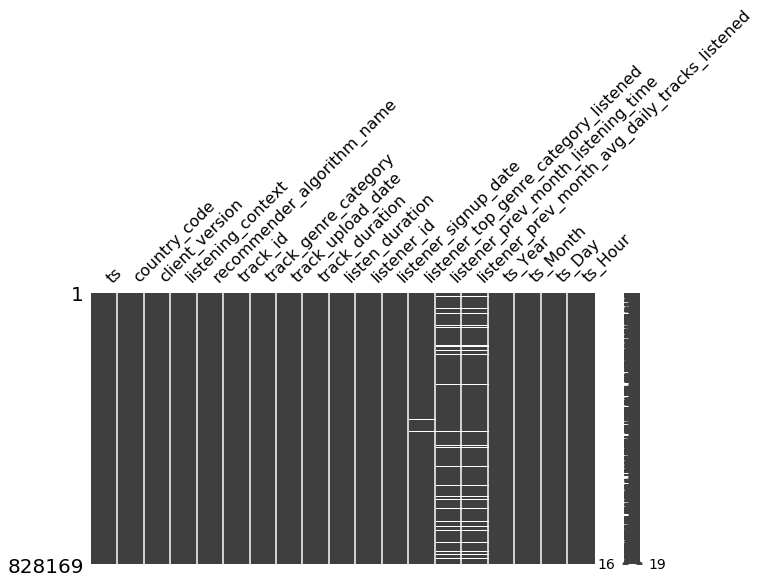

In [18]:
#Record Level missing value check

missingno.matrix(df,figsize=(10,5))

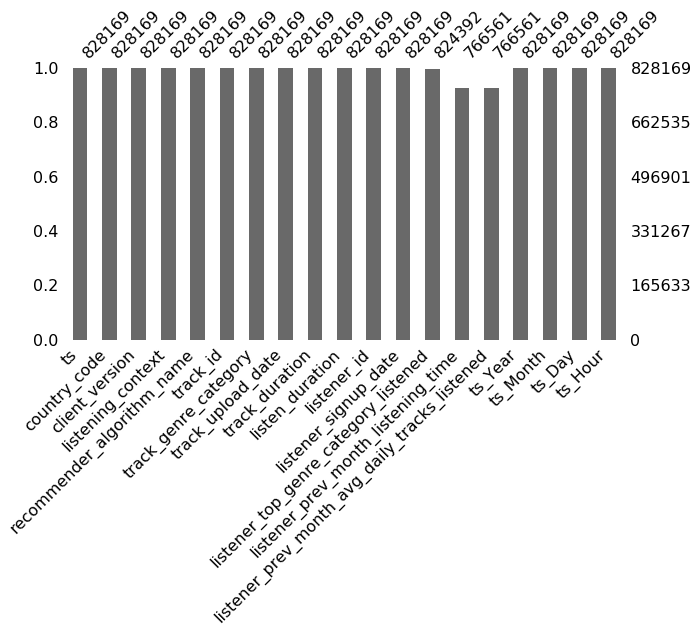

In [12]:
#Missing value distribution
missingno.bar(df,figsize=(10,5))

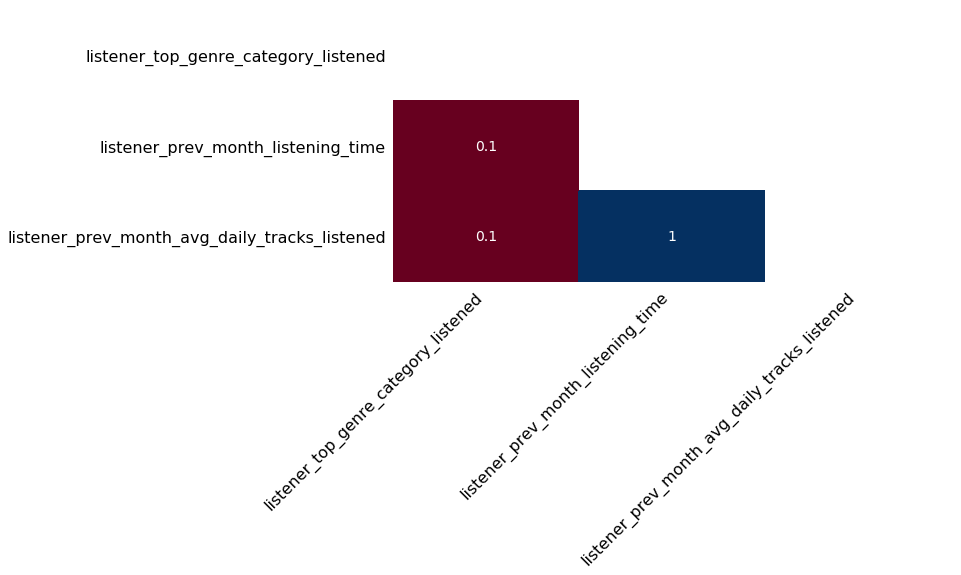

In [35]:
#Cross Section in Missing Values columns
missingno.heatmap(df,figsize=(10,5))

###### Missing %

In [32]:
print("Missing % in listener_prev_month_listening_time",round((df['listener_prev_month_listening_time'].isnull().sum()/df['listener_prev_month_listening_time'].count())*100),2)

print("Missing % in listener_prev_month_avg_daily_tracks_listened",round((df['listener_prev_month_avg_daily_tracks_listened'].isnull().sum()/df['listener_prev_month_avg_daily_tracks_listened'].count())*100),2)

print("Missing % in listener_top_genre_category_listened ",round((df['listener_top_genre_category_listened'].isnull().sum()/df['listener_top_genre_category_listened'].count())*100),2)

Missing % in listener_prev_month_listening_time 8.0 2
Missing % in listener_prev_month_avg_daily_tracks_listened 8.0 2
Missing % in listener_top_genre_category_listened  0.0 2


#### Missing Value check Summary

Below columns are having missing value which means we haven't captured information for some listner.

1. listener_top_genre_category_listened              3777
2. listener_prev_month_listening_time                61608
3. listener_prev_month_avg_daily_tracks_listened     61608

Hypothesis is 8 % of listner may not listen the song in previous month or we were not able to capture the information.

So Based on above hypothesis removing the missing listner records.

In [36]:
df=df.dropna()

In [37]:
df.shape

(765092, 19)

In [38]:
df.head()

,ts,country_code,client_version,listening_context,recommender_algorithm_name,track_id,track_genre_category,track_upload_date,track_duration,listen_duration,listener_id,listener_signup_date,listener_top_genre_category_listened,listener_prev_month_listening_time,listener_prev_month_avg_daily_tracks_listened,ts_Year,ts_Month,ts_Day,ts_Hour
0,2016-07-01 18:44:43,GB,204.0.20,tracks,content-based,b47911d0e80d1a8a959a2b726654bbfa,Dance & Electronic,2016-06-23 00:00:00,413933,413933,0001d5755511cae40e5b32d83a3decce,2011-12-25 00:00:00,HipHop & R&B,617270940.0,22.5,2016,7,4,18
1,2016-07-01 18:48:44,GB,204.0.20,tracks,content-based,1f5e4bc82ba7fc802f780870f9b69191,HipHop & R&B,2016-06-24 00:00:00,402640,110722,0001d5755511cae40e5b32d83a3decce,2011-12-25 00:00:00,HipHop & R&B,617270940.0,22.5,2016,7,4,18
2,2016-07-06 15:57:16,GB,204.0.20,users,content-based,092495283958e5d00f61cf2afe970d83,Pop,2016-06-28 00:00:00,494811,193818,0001d5755511cae40e5b32d83a3decce,2011-12-25 00:00:00,HipHop & R&B,617270940.0,22.5,2016,7,2,15
3,2016-07-01 19:39:11,US,36.0.8,collection,content-based,211cd7be59941679f5ea847879b3b19b,HipHop & R&B,2014-06-09 00:00:00,361585,361585,000264c5b34ad04999535c8b6a8b86e2,2013-09-17 00:00:00,HipHop & R&B,112239180.0,10.5,2016,7,4,19
4,2016-07-01 19:42:39,US,36.0.8,collection,content-based,0e7ca1a7524aba84473540fa0d0ec75f,Pop,2015-11-28 00:00:00,373700,160162,000264c5b34ad04999535c8b6a8b86e2,2013-09-17 00:00:00,HipHop & R&B,112239180.0,10.5,2016,7,4,19


### Setting Hypothesis

Hypothesis is if listner listening duration of recommended song is <=50% of track duration then listner didn't like the recommnded song.

Based on above hypothesis added the like_dislike column. 

1. Value "0": Indicate Listner liked the recommended song.
2.  Value "1": Indicate Listner haven't liked the recommended song.

In [40]:
df['Like_dislike']=np.where(df['listen_duration']<=df['track_duration']/2,1,0)

C:\Users\sachin.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [43]:
df.loc[:,['track_duration','listen_duration','Like_dislike']].head()

,track_duration,listen_duration,Like_dislike
0,413933,413933,0
1,402640,110722,1
2,494811,193818,1
3,361585,361585,0
4,373700,160162,1


In [49]:
# using dictionary to convert specific columns 
convert_dict = {'ts_Year': object, 
                'ts_Month': object,
                'ts_Day': object,
                'ts_Hour': object,
                'Like_dislike': object,
               } 
  
df = df.astype(convert_dict) 
print(df.dtypes) 

ts                                                object
country_code                                      object
client_version                                    object
listening_context                                 object
recommender_algorithm_name                        object
track_id                                          object
track_genre_category                              object
track_upload_date                                 object
track_duration                                     int64
listen_duration                                    int64
listener_id                                       object
listener_signup_date                              object
listener_top_genre_category_listened              object
listener_prev_month_listening_time               float64
listener_prev_month_avg_daily_tracks_listened    float64
ts_Year                                           object
ts_Month                                          object
ts_Day                         

#### Intial Handshake with data

In [47]:
print("Distinct Recommmended tracks:=",df['track_id'].nunique())
print("Distinct listener:=",df['listener_id'].nunique())

Distinct Recommmended tracks:= 359055
Distinct listener:= 49547


In [50]:
df.describe()

,track_duration,listen_duration,listener_prev_month_listening_time,listener_prev_month_avg_daily_tracks_listened
count,7.650920e+05,7.650920e+05,7.650920e+05,765092.000000
mean,5.226777e+05,2.982132e+05,7.960725e+09,45.794938
std,9.907958e+05,5.270887e+05,1.011642e+10,43.165134
min,0.000000e+00,-7.049300e+04,0.000000e+00,1.500000
25%,3.025630e+05,3.969700e+04,1.183196e+09,16.500000
50%,3.743880e+05,2.785620e+05,4.417111e+09,33.000000
75%,4.530220e+05,3.950080e+05,1.101478e+10,61.500000
max,4.200407e+07,3.465427e+07,1.264765e+11,637.500000


In [51]:
df.describe(include=['O'])

,ts,country_code,client_version,listening_context,recommender_algorithm_name,track_id,track_genre_category,track_upload_date,listener_id,listener_signup_date,listener_top_genre_category_listened,ts_Year,ts_Month,ts_Day,ts_Hour,Like_dislike
count,765092,765092,765092,765092,765092,765092,765092,765092,765092,765092,765092,765092,765092,765092,765092,765092
unique,628409,2,220,9,4,359055,13,2664,49547,2692,12,1,2,7,24,2
top,2016-07-19 21:13:00,US,204.0.0,tracks,content-based,e2402bbc211467dfc821da77e4ab5677,HipHop & R&B,2016-06-22 00:00:00,0c5439d9e0faa9415c25893efb17e115,2013-10-22 00:00:00,HipHop & R&B,2016,7,6,21,0
freq,30,484990,388184,443121,685582,1007,407113,5932,4809,4990,506331,765092,652686,127757,45610,493141


### Features weitage to drive like and dislike

In [56]:
df[df['Like_dislike']==1]['listener_id'].count()

271951

In [ ]:
df.groupby('Like_dislike')

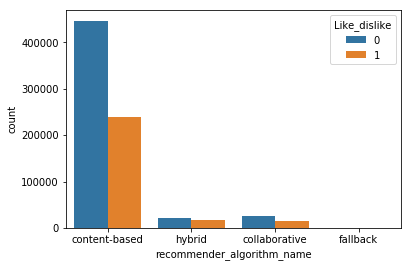

In [57]:
sns.countplot(x='recommender_algorithm_name', hue='Like_dislike', data =df)

[Text(0,0,'HipHop & R&B'),
 Text(0,0,'Dance & Electronic'),
 Text(0,0,'Metal'),
 Text(0,0,'Classical'),
 Text(0,0,'Pop'),
 Text(0,0,'Reggae'),
 Text(0,0,'Speech'),
 Text(0,0,'World'),
 Text(0,0,'Latin'),
 Text(0,0,'Rock'),
 Text(0,0,'Jazz'),
 Text(0,0,'Country')]

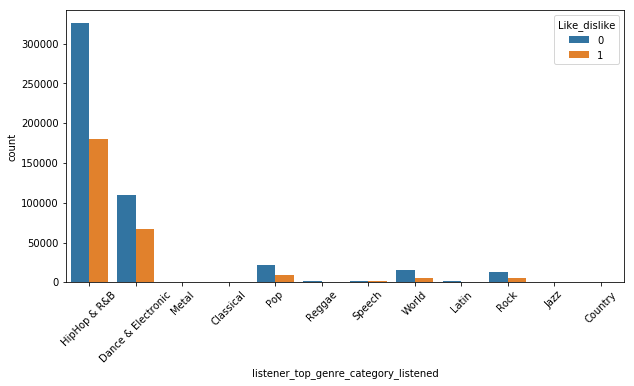

In [64]:
#sns.countplot(x='listener_top_genre_category_listened', hue='Like_dislike', data =df)


plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=df,
    x='listener_top_genre_category_listened',
    hue='Like_dislike'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

[Text(0,0,'tracks'),
 Text(0,0,'users'),
 Text(0,0,'collection'),
 Text(0,0,'playlists'),
 Text(0,0,'stream'),
 Text(0,0,'you'),
 Text(0,0,'search'),
 Text(0,0,'personal-recommended'),
 Text(0,0,'charts')]

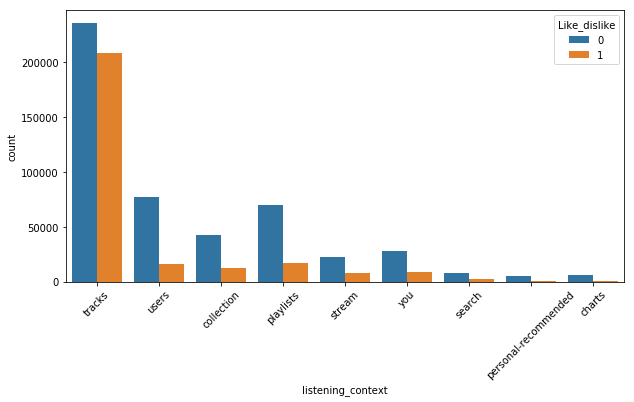

In [63]:
#sns.countplot(x='listening_context', hue='Like_dislike', data =df)

plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=df,
    x='listening_context',
    hue='Like_dislike'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)


In [28]:
df.groupby('ts_Month')['listener_prev_month_avg_daily_tracks_listened'].mean()

ts_Month
6    48.943376
7    45.176061
Name: listener_prev_month_avg_daily_tracks_listened, dtype: float64

In [ ]:
df['ts_Month'].unique()

In [29]:
df.groupby('ts_Month')['listener_id'].count()

ts_Month
6    118240
7    709929
Name: listener_id, dtype: int64

In [12]:
df[df['listener_prev_month_listening_time'].isnull()].head()

,ts,country_code,client_version,listening_context,recommender_algorithm_name,track_id,track_genre_category,track_upload_date,track_duration,listen_duration,listener_id,listener_signup_date,listener_top_genre_category_listened,listener_prev_month_listening_time,listener_prev_month_avg_daily_tracks_listened,ts_Year,ts_Month,ts_Day,ts_Hour
121,2016-06-26 19:12:22,US,36.4.20,tracks,collaborative,eb23bfabf4d46ff4f2fb3e0caedcaea8,Speech,2015-12-15 00:00:00,426781,14721,000475010431369b2de9db784135acd0,2013-11-17 00:00:00,Jazz,NaN,NaN,2016,6,6,19
154,2016-06-26 03:12:38,GB,204.0.0,users,content-based,b8322e103ad39ef30d2b13ea7fc2ac2e,Pop,2016-02-23 00:00:00,371691,17804,000c7ab2b64e766d98a5e174671ef574,2016-04-28 00:00:00,HipHop & R&B,NaN,NaN,2016,6,6,3
182,2016-06-27 16:45:09,US,152.0.32,tracks,content-based,270bd39b2552409581786fa0da861fc9,Dance & Electronic,2016-03-24 00:00:00,557125,557125,00152c7d930da31e8c1b017be89a6109,2015-02-27 00:00:00,Dance & Electronic,NaN,NaN,2016,6,0,16
183,2016-06-27 16:50:28,US,152.0.32,tracks,content-based,26ad976778ddee6a568d9b37fb858b6f,Dance & Electronic,2016-04-15 00:00:00,877704,877704,00152c7d930da31e8c1b017be89a6109,2015-02-27 00:00:00,Dance & Electronic,NaN,NaN,2016,6,0,16
184,2016-06-27 16:58:50,US,152.0.32,tracks,content-based,611fe9765b6fed7c30a4eb588bcc12cd,HipHop & R&B,2016-04-15 00:00:00,744753,744753,00152c7d930da31e8c1b017be89a6109,2015-02-27 00:00:00,Dance & Electronic,NaN,NaN,2016,6,0,16


In [ ]:
df[df['listen_duration']<0]['listener_id'].plot().hist()

print("Negative Listen duration:",df[df['listen_duration']<0]['listener_id'].count())

In [34]:
(df[df['listen_duration']<df['listen_duration'].mean()]['listener_id'].count()/df['listener_id'].count())*100

53.27946349114734

In [ ]:
sns.boxplot(x='listen_duration',y='ts_Month', data=df, palette='winter')
sns.set_style('whitegrid')

In [ ]:
sns.boxplot(x='listen_duration',y='recommender_algorithm_name', data=df, palette='winter')
sns.set_style('whitegrid')

In [ ]:
sns.boxplot(x='listen_duration',y='listener_top_genre_category_listened', data=df, palette='winter')
sns.set_style('whitegrid')